### FARM: eCDF-SPC Module Training

This notebook is intended to show how the eCDF-SPC module within FARM framework is trained for fault detection. The main source code of ecdf_model is available in models.py file.

In [1]:
import numpy as np
import pandas as pd
from models import eCDF_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from utils import prepare_train, load_ic_data,load_oc, SVM_fault_diag, plot_conf
import pickle
import matplotlib.pyplot as plt
import gc

import multiprocessing
from joblib import Parallel, delayed

The data provided here are simulation generated data using MATLAB GUI proposed by Andersen et al. [1].

In [2]:
ic_data = load_ic_data()

a set of 12000 in-control simulations are loaded!


In [3]:
ic_train_norm, ic_test, train_means, train_stds = prepare_train(ic_data)

Number of train simulations: 9600
ic-train Normalized!


# Fault Detection with eCDF

We will make an object from the `eCDF_model` and give the required parameters of the model. These parameters are $k$, $r$, $ARL_0$ and a reference in-control historical data. 

In [4]:
spc_model = eCDF_model(k=1.3, r=4, ARL0=500, hist_data=ic_train_norm[0]) 

The eCDF model has a `fit` method which is does the model training using the bisection method to find the in-control threshold $H$ that corresponds to the desired $ARL_0$. Here we will use ARL0 = 370.

In [5]:
H, ARL0i, RL0_list = spc_model.fit(ic_train_norm, 2000,0)

Number of CPU cores: 10


Calculating RL0s: 100%|██████████| 9600/9600 [00:31<00:00, 307.17it/s]


Calculated ARL0 = 164.19 for H = 1000.00 and k = 1.3


Calculating RL0s: 100%|██████████| 9600/9600 [00:54<00:00, 175.23it/s]


Calculated ARL0 = 322.95 for H = 1500.00 and k = 1.3


Calculating RL0s: 100%|██████████| 9600/9600 [01:14<00:00, 128.97it/s]


Calculated ARL0 = 438.08 for H = 1750.00 and k = 1.3


Calculating RL0s: 100%|██████████| 9600/9600 [01:21<00:00, 118.08it/s]


Calculated ARL0 = 501.26 for H = 1875.00 and k = 1.3


The in-control threshold is a property eCDF model and can be accessed after training by `spc_model.H`

In [6]:
spc_model.H

1875.0

At this stage the FARM's eCDF module is ready for online monitoring of data streams for fault detection.

Now we can detect a fault using the `spc_model`'s `monitor` method. As an example, for fault 1 of TEP we can see below:

In [7]:
faulty_data = load_oc(fault=1)

# normalizing faulty data with train_means and train_stds
sample_simulation = (faulty_data[0] - train_means) / train_stds
n_alarms, global_stats, faulty_index = spc_model.monitor(sample_simulation)

RL1 = faulty_index[0]

print(f"Number of alarms: {n_alarms} out of {len(sample_simulation)} samples. FDR = {n_alarms/len(sample_simulation):.4f} for sample 1 of fault 1")
print(f"FDS = {RL1}")

a set of 500 out-of-control simulations for fault 1 is loaded!
Number of alarms: 1560 out of 1664 samples. FDR = 0.9375 for sample 1 of fault 1
FDS = 104


In [9]:
# deleting faulty_data fault 1 for memory efficiency

del ic_train_norm, ic_test, faulty_data
gc.collect()

0

# Fault Diagnosis with SVM

In [8]:
def monitor_faulty_data(faulty_data, spc_model, train_means, train_stds):
    """
    Function to monitor faulty data using the SPC model.
    """
    # normalizing faulty data with train_means and train_stds
    output = Parallel(n_jobs=multiprocessing.cpu_count())(
        delayed(spc_model.cdf)((faulty_data[i] - train_means) / train_stds , spc_model.H) for i in tqdm(range(len(faulty_data))))

    RL1_list = [output[i][0] for i in range(len(output))]

    return RL1_list

In [9]:
# loading all faulty data
faulty_data = load_oc()
RL1_list = monitor_faulty_data(faulty_data, spc_model, train_means, train_stds)


a set of 10000 out-of-control simulations for all faults is loaded!


  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
patience_time = 700

faults = [i for i in range(1,21)]

# making fault labels
y = list()
for fault in faults:
    for _ in range(500):
        y.append(fault)



best_estimator, cm, train_acc, test_acc = SVM_fault_diag(X=faulty_data, y=y, patience_time=patience_time, RL_list = RL1_list,ic_mean=train_means, 
                                                        ic_std=train_stds,t_shift=500,windowing=True, 
                                                        call_all=False, ic_append=True, include_stats=False, 
                                                        scaling=False, compression=False, mapping=True, tuning=True)


Patience time is set to 700
a set of 10000 in-control simulations are loaded!
Window size = 926
Mapping the windowed data to the tangent space
10000 covariances are mapped
The whole data has shape: (10000, 2116)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


Python(18736) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18737) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18738) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18739) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18740) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18744) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18746) Malloc

[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=  58.5s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=  58.9s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=  59.4s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=  59.5s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=  59.6s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time= 1.0min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time= 1.0min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time= 1.0min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time= 1.0min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time= 1.0min
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=  53.3s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=  53.3s
[CV] END ...................

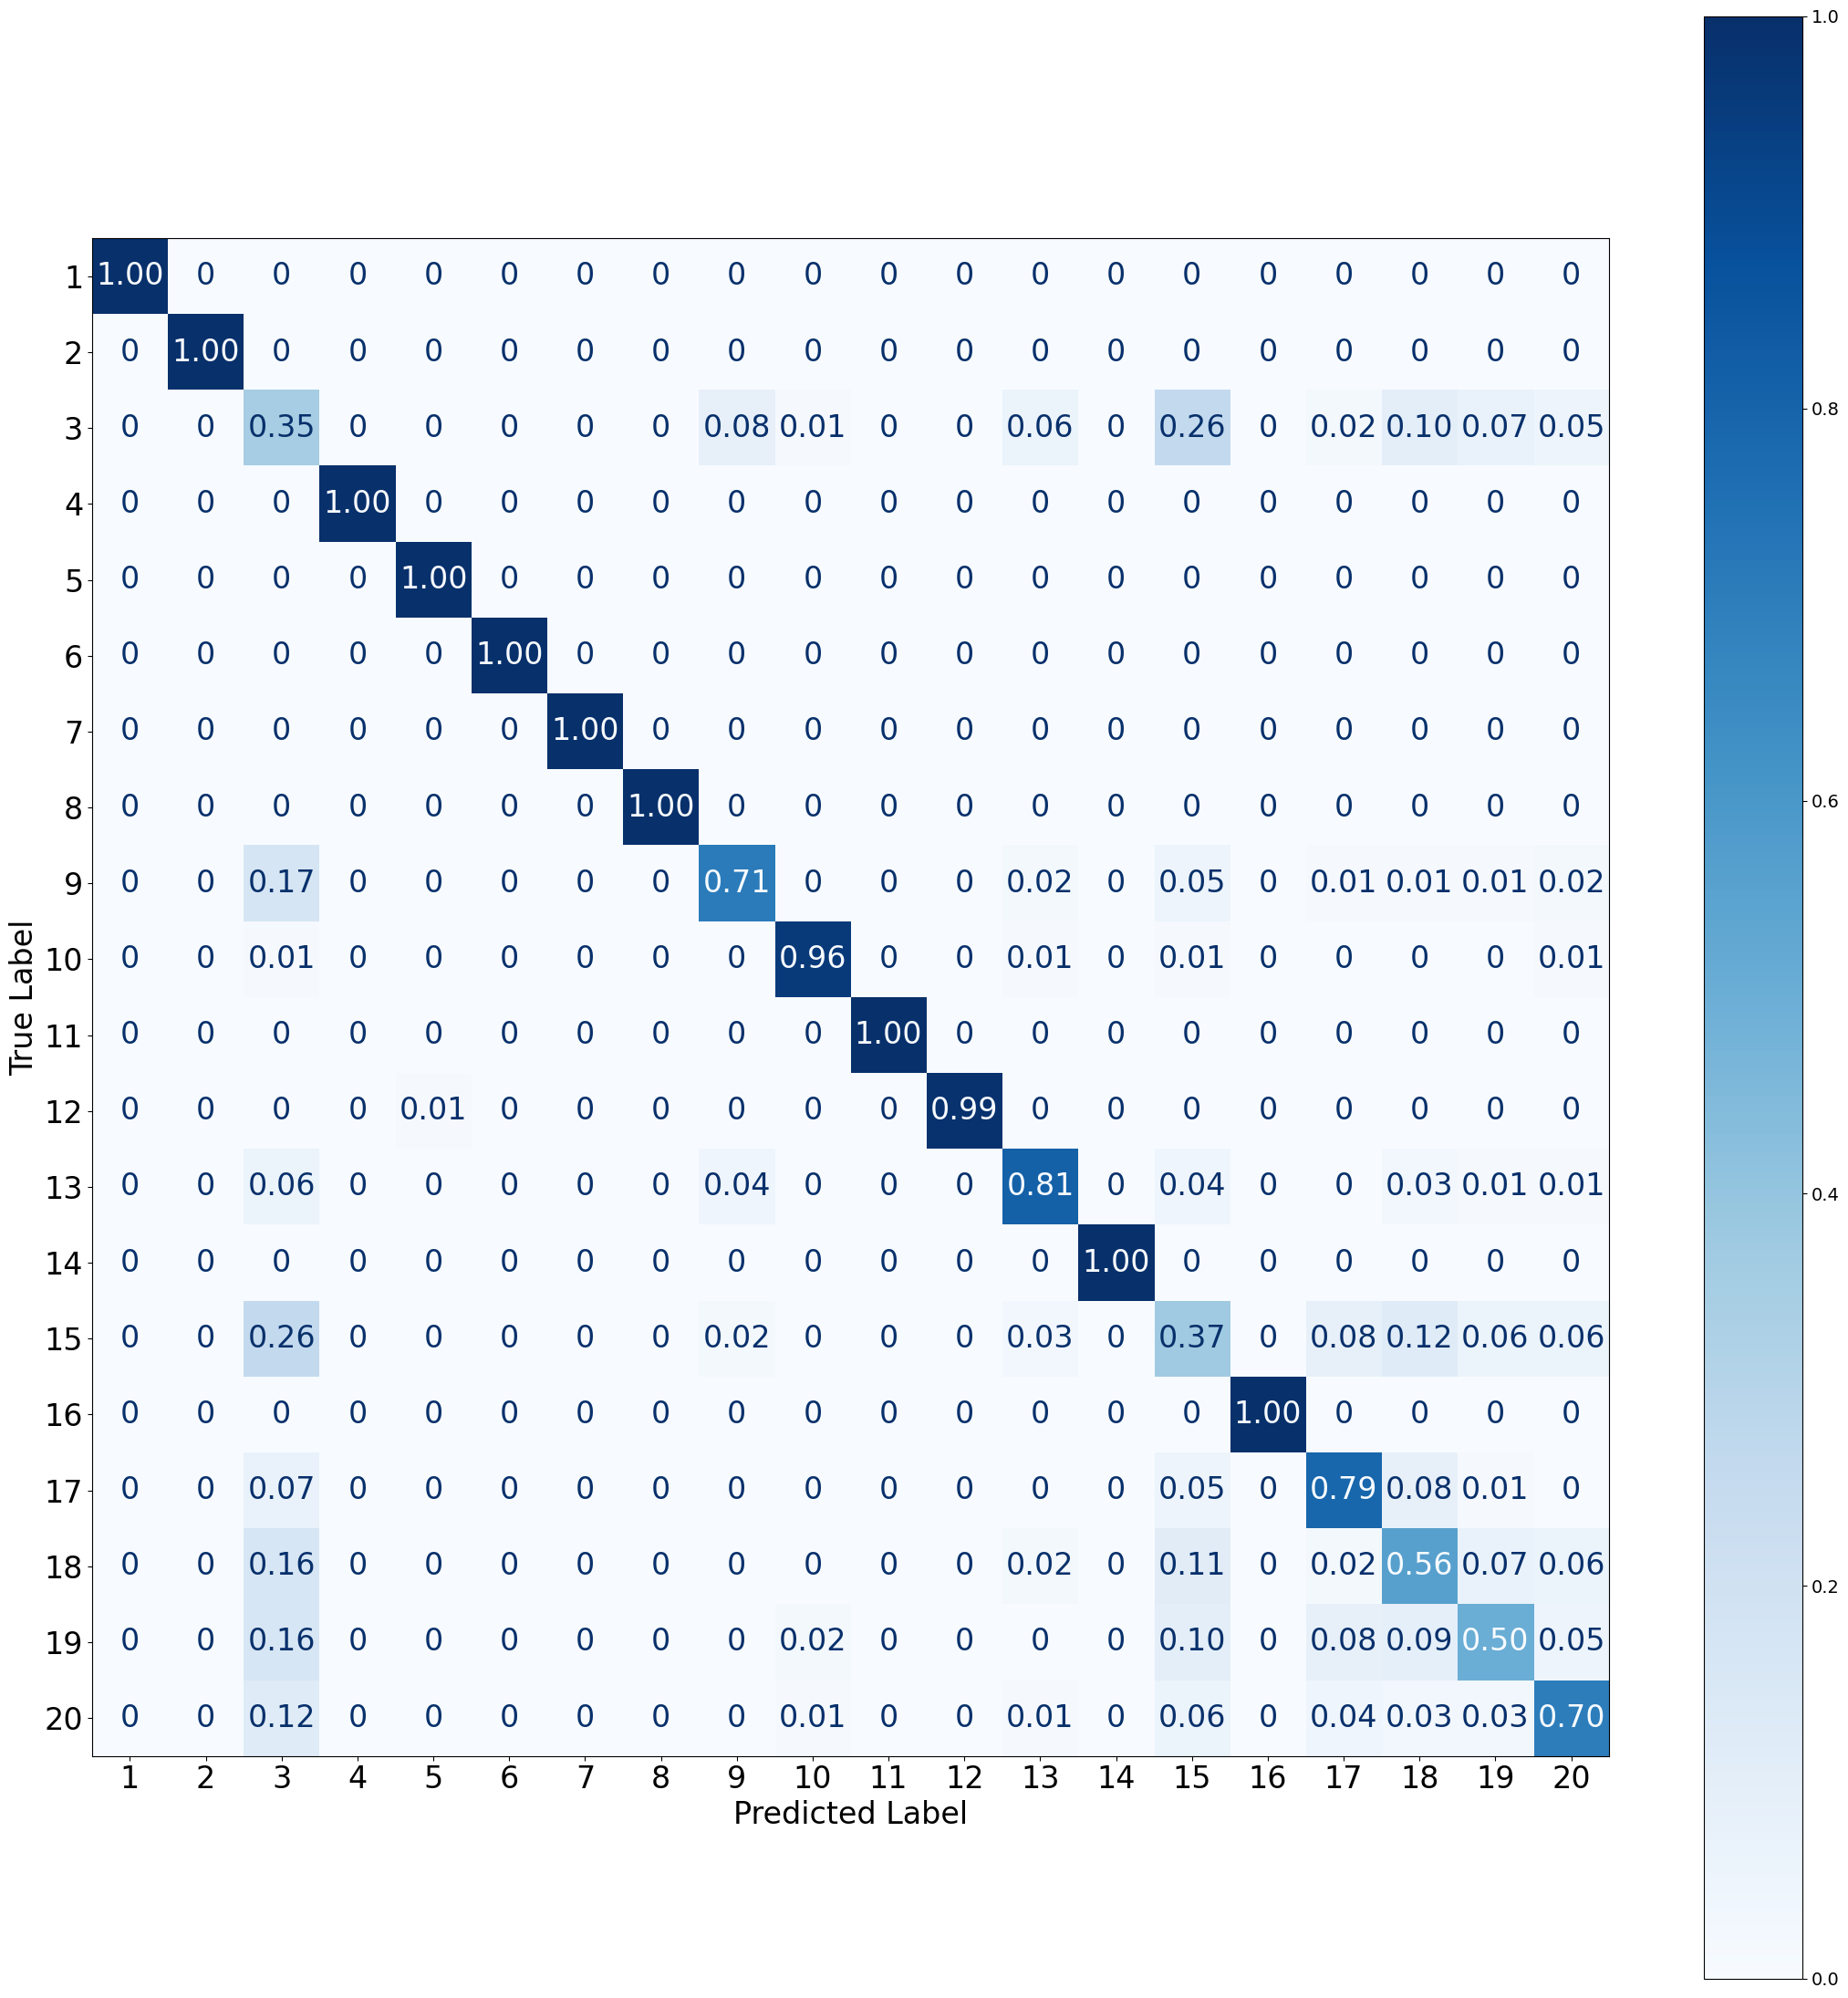

In [15]:
plot_conf(cm, figure_size=(22,22), label_fontsize=24, number_fontsize=24)